In [364]:
# SETUP & IMPORTS
# Purpose: Import core libraries for data handling, visualization, and numerical operations.
# - pandas: data manipulation and analysis
# - matplotlib/seaborn: visualization
# - numpy: numerical operations
# - pd.set_option: ensure full column visibility when inspecting DataFrames
# - sns.set: define a clean visualization style

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Display up to 200 columns (useful for wide one-hot encoded data)
pd.set_option('display.max_columns', 200)

# Set seaborn default style for clean white-grid plots
sns.set(style="whitegrid")

In [362]:
# --- Reproducibility & environment info ---
import os, random, sys, platform, numpy as np

SEED = 42  # single source of truth

# Python, NumPy, and general RNG seeds
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

#For frameworks that support global seeds beyond sklearn/xgboost
try:
    import torch
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except Exception:
    pass

# Quick environment print (helps future reproducibility)
print(f"Python: {platform.python_version()} | OS: {platform.system()} {platform.release()}")

Python: 3.12.4 | OS: Darwin 24.4.0


In [71]:
# ==== Loading the dataset ====
# Purpose: Load the raw German used car dataset from CSV into a pandas DataFrame.
# - GERMANY_PATH: file path to the dataset (adjust if filename/location differs).
# - pd.read_csv: reads CSV file into DataFrame.
# - low_memory=False: prevents dtype guessing issues when columns contain mixed types.
# - Print statements: confirm dataset dimensions and preview first 40 column names 
#   (useful for checking structure before preprocessing).

GERMANY_PATH = "germany dataset.csv"   # <-- update path if necessary

# Read dataset
df = pd.read_csv(GERMANY_PATH, low_memory=False)

# Output raw shape and first 40 column names for verification
print("Raw shape:", df.shape)
print(df.columns.tolist()[:40])

Raw shape: (46405, 9)
['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'price', 'hp', 'year']


In [89]:
# Quick inspection of the first 5 rows of the dataset
# Purpose: sanity check that the dataset has loaded correctly 
# and that column names, data types, and sample values look as expected.
df.head()

,mileage_km,make,model,fuel_type,Transmission,new_or_used,price_EUR,hp,car_age
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,14
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,14
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,14
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,14
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,14


In [77]:
# Inspect the last 5 rows of the dataset
# Purpose: cross-check that data loaded fully, 
# ensure no unexpected formatting issues or truncated rows at the file’s end.
df.tail()

,mileage,make,model,fuel,gear,offerType,price,hp,year
46400,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46401,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46402,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46403,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021
46404,99,Fiat,500,Electric/Gasoline,Manual,Pre-registered,12990,71.0,2021


In [73]:
# Number of rows and columns
print("Rows:", df.shape[0])
print("Columns:", df.shape[1])
df.size   # total number of entries (rows × columns)

Rows: 46405
Columns: 9


417645

In [79]:
# Check dataset structure, column types, and non-null counts
# Purpose: 
# - Identify variable data types (int, float, object) for later preprocessing.
# - Spot columns with missing values by reviewing non-null counts.
# - Confirm total row count consistency with df.shape.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46405 entries, 0 to 46404
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    46405 non-null  int64  
 1   make       46405 non-null  object 
 2   model      46262 non-null  object 
 3   fuel       46405 non-null  object 
 4   gear       46223 non-null  object 
 5   offerType  46405 non-null  object 
 6   price      46405 non-null  int64  
 7   hp         46376 non-null  float64
 8   year       46405 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.2+ MB


In [81]:
# Print the total number of data entries (elements) in the DataFrame
# Purpose: 
# - df.size = total cells (rows × columns).
# - Useful for verifying dataset scale before preprocessing 
#   and cross-checking with shape and memory usage.
print (df.size)

417645


In [83]:
current_year = 2025   # Define current year for age calculation (can be parameterized for reproducibility)

# Create new feature: car_age
# Purpose:
# - Convert absolute "year" into relative "car_age", which is a stronger predictor of price.
# - This transformation captures depreciation effects better than raw year values.
df["car_age"] = current_year - df["year"]

# Drop original "year" column to avoid redundancy/multicollinearity
df = df.drop(columns=["year"])

In [85]:
# Rename columns for consistency
df = df.rename(columns={
    "offerType": "new_or_used",
    "mileage": "mileage_km",
    "fuel": "fuel_type",
    "price": "price_EUR",
    "gear": "Transmission",

})

print("Updated columns:", df.columns.tolist())

Updated columns: ['mileage_km', 'make', 'model', 'fuel_type', 'Transmission', 'new_or_used', 'price_EUR', 'hp', 'car_age']


In [91]:
from sklearn.model_selection import train_test_split

# Define feature sets
# - FEATURES_NUM: numerical predictors (continuous variables like age, mileage, horsepower)
# - FEATURES_CAT: categorical predictors (make, model, fuel type, etc.)
# - TARGET: dependent variable (car price in EUR)
FEATURES_NUM = ["car_age", "mileage_km", "hp"]
FEATURES_CAT = ["make", "model", "fuel_type", "Transmission", "new_or_used"]
TARGET = "price_EUR"

# Separate predictors (X) and target (y)
# Purpose: standard supervised ML structure
X = df[FEATURES_NUM + FEATURES_CAT].copy()
y = df[TARGET].copy()

# Train-test split
# - test_size=0.2: hold out 20% of data for unbiased evaluation
# - random_state=42: fixed seed for reproducibility of split
# - Stratification not used here because target is continuous (not classification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [93]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ColumnTransformer: applies different preprocessing to numeric and categorical features
# - "num": StandardScaler -> standardises numerical variables (mean=0, variance=1).
#   Purpose: ensures comparability of features in Linear Regression (sensitive to scale).
# - "cat": OneHotEncoder -> encodes categorical variables into binary indicators (0/1).
#   handle_unknown="ignore": prevents errors if unseen categories appear in test data.
# Purpose: create a unified preprocessing pipeline so that all models can use consistent inputs.
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), FEATURES_NUM),
        ("cat", OneHotEncoder(handle_unknown="ignore"), FEATURES_CAT),
    ]
)

In [101]:
# Check missing values in the dataset
missing_summary = df.isna().sum().sort_values(ascending=False)

print("Missing values per column:\n", missing_summary)
print("\nTotal rows in dataset:", len(df))
print("Rows with any NaN:", df.isna().any(axis=1).sum())

Missing values per column:
 Transmission    182
model           143
hp               29
mileage_km        0
make              0
fuel_type         0
new_or_used       0
price_EUR         0
car_age           0
dtype: int64

Total rows in dataset: 46405
Rows with any NaN: 334


In [109]:
#Missing values & duplicates ---

# Quick look at NaNs per column
na_counts = df.isna().sum().sort_values(ascending=False)
print("Missing values per column:\n", na_counts, "\n")
print("Rows with any NaN:", df.isna().any(axis=1).sum())

# Drop rows with ANY NaN (small share, simplest/cleanest choice)
df = df.dropna()
print("Shape after dropna():", df.shape)

# Optional: drop exact duplicate rows (rare but cheap to do)
before = len(df)
df = df.drop_duplicates()
print(f"Duplicates removed: {before - len(df)}  | New shape: {df.shape}")

Missing values per column:
 mileage_km      0
make            0
model           0
fuel_type       0
Transmission    0
new_or_used     0
price_EUR       0
hp              0
car_age         0
dtype: int64 

Rows with any NaN: 0
Shape after dropna(): (46071, 9)
Duplicates removed: 2124  | New shape: (43947, 9)


In [105]:
df.head()

,mileage_km,make,model,fuel_type,Transmission,new_or_used,price_EUR,hp,car_age
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,14
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,14
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,14
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,14
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,14


/var/folders/wk/g1wcsyhj1yqccbrjstc2snh40000gn/T/ipykernel_27170/1782107643.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_prices.index, y=avg_prices.values, palette="Set2")


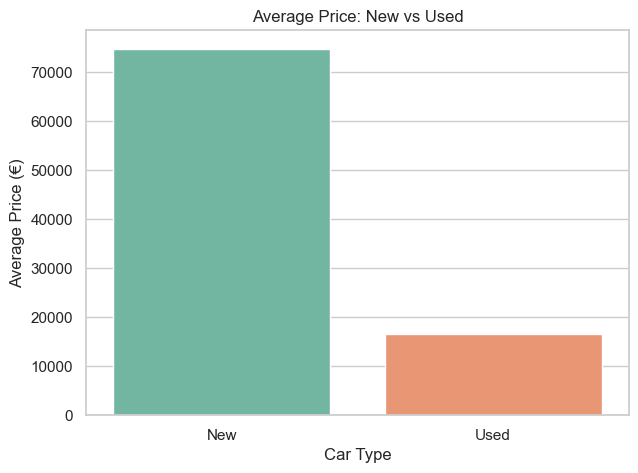

In [271]:
# Map categories only for visualization
df_plot = df.copy()
df_plot["new_simple"] = df_plot["new_or_used"].replace({
    "Demonstration": "Used",
    "Pre-registered": "Used",
    "Employee's car": "Used"
    # "New" and "Used" stay as they are
})

# ---- Average price bar chart ----
plt.figure(figsize=(7,5))
avg_prices = df_plot.groupby("new_simple")["price_EUR"].mean().sort_values(ascending=False)
sns.barplot(x=avg_prices.index, y=avg_prices.values, palette="Set2")
plt.title("Average Price: New vs Used")
plt.ylabel("Average Price (€)")
plt.xlabel("Car Type")
plt.show()



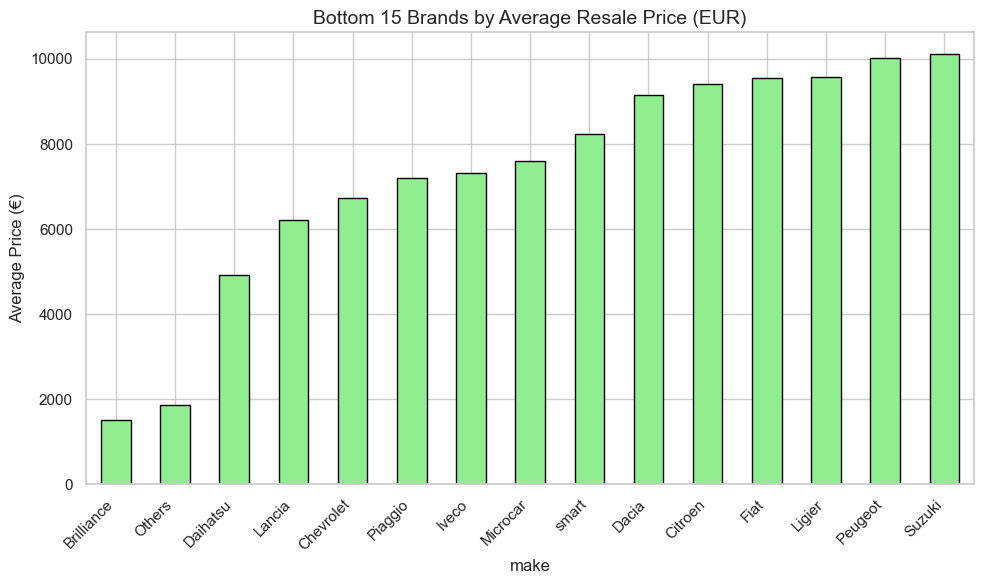

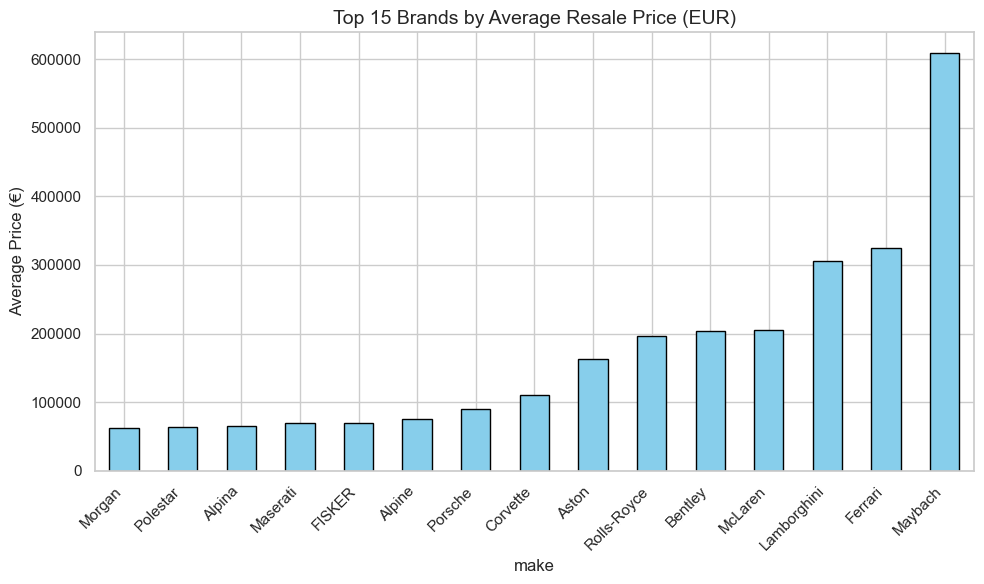

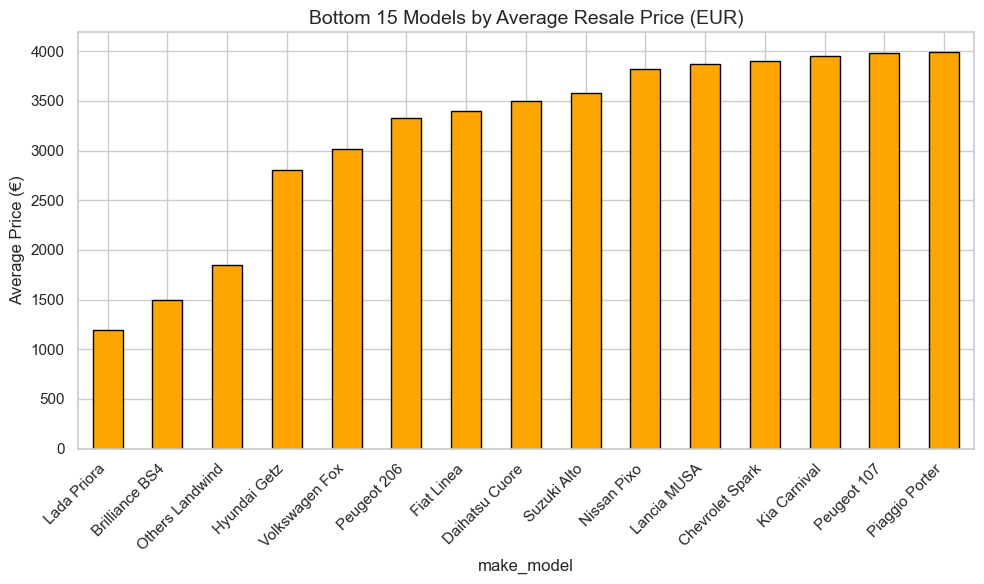

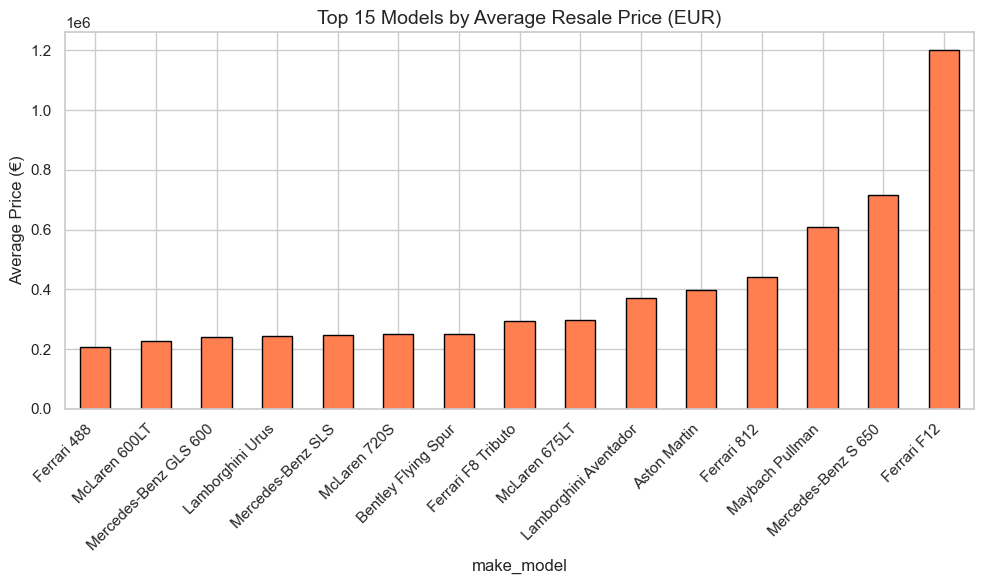

In [238]:
# === BRAND LEVEL ===
brand_avg = df.groupby("make")["price_EUR"].mean().sort_values()

# Bottom 15 (cheapest brands)
plt.figure(figsize=(10,6))
brand_avg.head(15).plot(kind="bar", color="lightgreen", edgecolor="black")
plt.title("Bottom 15 Brands by Average Resale Price (EUR)", fontsize=14)
plt.ylabel("Average Price (€)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Top 15 (most expensive brands)
plt.figure(figsize=(10,6))
brand_avg.tail(15).plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Top 15 Brands by Average Resale Price (EUR)", fontsize=14)
plt.ylabel("Average Price (€)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# === MODEL LEVEL ===
df["make_model"] = df["make"] + " " + df["model"].astype(str)
model_avg = df.groupby("make_model")["price_EUR"].mean().sort_values()

# Bottom 15 (cheapest models)
plt.figure(figsize=(10,6))
model_avg.head(15).plot(kind="bar", color="orange", edgecolor="black")
plt.title("Bottom 15 Models by Average Resale Price (EUR)", fontsize=14)
plt.ylabel("Average Price (€)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Top 15 (most expensive models)
plt.figure(figsize=(10,6))
model_avg.tail(15).plot(kind="bar", color="coral", edgecolor="black")
plt.title("Top 15 Models by Average Resale Price (EUR)", fontsize=14)
plt.ylabel("Average Price (€)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [111]:
# Define target and features
TARGET = "price_EUR"   # what we want to predict
FEATURES_NUM = ["car_age", "mileage_km", "hp"]   # numeric features
FEATURES_CAT = ["make", "model", "fuel_type", "Transmission", "new_or_used"]  # categorical features

X = df[FEATURES_NUM + FEATURES_CAT].copy()
y = df[TARGET].copy()

# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# Preprocessor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), FEATURES_NUM),
        ("cat", OneHotEncoder(handle_unknown="ignore"), FEATURES_CAT)
    ]
)

# Linear Regression Pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

lr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

#  Train
lr_model.fit(X_train, y_train)

#  Predict
y_pred_lr = lr_model.predict(X_test)

Evaluate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

r2 = r2_score(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae = mean_absolute_error(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"R²   : {r2:.3f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAE  : {mae:.2f}")

Train shape: (35157, 8)
Test shape: (8790, 8)
Linear Regression Performance:
R²   : 0.869
RMSE : 6120.78
MAE  : 2877.85


In [113]:
# ==== Random Forest Regressor ====
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=200,   # number of trees
        max_depth=None,    # let trees expand fully
        random_state=42,
        n_jobs=-1
    ))
])

# Train
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("\nRandom Forest Performance:")
print(f"R²   : {r2_rf:.3f}")
print(f"RMSE : {rmse_rf:.2f}")
print(f"MAE  : {mae_rf:.2f}")


Random Forest Performance:
R²   : 0.929
RMSE : 4508.30
MAE  : 1879.01


In [115]:
# ==== XGBoost Regressor ====
from xgboost import XGBRegressor

xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=500,     # more trees than RF
        learning_rate=0.05,   # step size
        max_depth=6,          # tree depth
        subsample=0.8,        # row sampling
        colsample_bytree=0.8, # feature sampling
        random_state=42,
        n_jobs=-1
    ))
])

# Train
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("\nXGBoost Performance:")
print(f"R²   : {r2_xgb:.3f}")
print(f"RMSE : {rmse_xgb:.2f}")
print(f"MAE  : {mae_xgb:.2f}")


XGBoost Performance:
R²   : 0.929
RMSE : 4495.94
MAE  : 2121.01


Model Performance Comparison (sorted by R²):


,R²,RMSE,MAE
Model,,,
XGBoost,0.929,4495.94,2121.01
Random Forest,0.929,4508.30,1879.01
Linear Regression,0.869,6120.78,2877.85


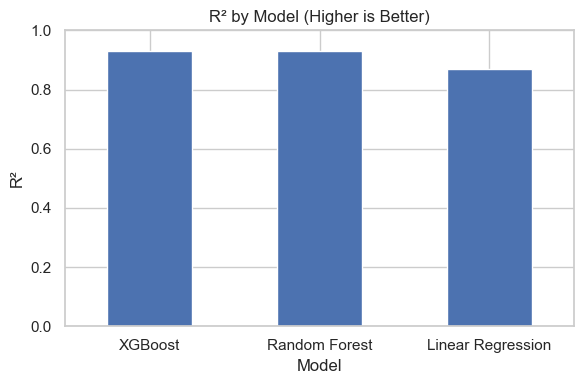

<Figure size 700x400 with 0 Axes>

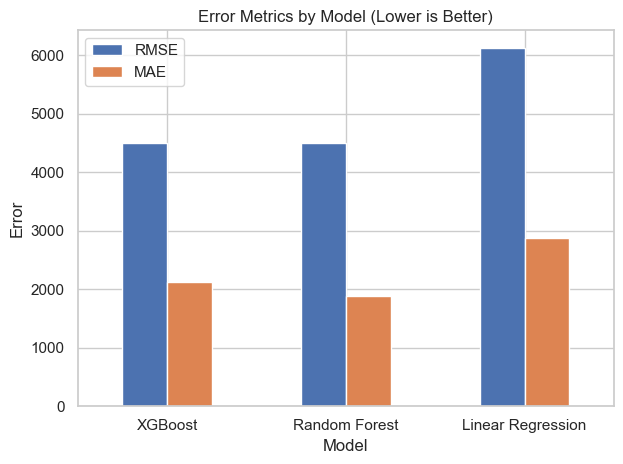

In [117]:

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# helper to compute metrics nicely
def model_metrics(y_true, y_pred):
    return {
        "R²": r2_score(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred)
    }

# build comparison table assumes y_pred_* from your three models
rows = []
rows.append({"Model": "Linear Regression", **model_metrics(y_test, y_pred_lr)})
rows.append({"Model": "Random Forest", **model_metrics(y_test, y_pred_rf)})
rows.append({"Model": "XGBoost", **model_metrics(y_test, y_pred_xgb)})

results_df = pd.DataFrame(rows).set_index("Model").sort_values("R²", ascending=False)

# round for pretty display
results_rounded = results_df.copy()
results_rounded["R²"] = results_rounded["R²"].round(3)
results_rounded["RMSE"] = results_rounded["RMSE"].round(2)
results_rounded["MAE"] = results_rounded["MAE"].round(2)

print("Model Performance Comparison (sorted by R²):")
display(results_rounded)  # works in Jupyter; use print(results_rounded) elsewhere


# R² bar chart
plt.figure(figsize=(6,4))
results_df["R²"].plot(kind="bar")
plt.title("R² by Model (Higher is Better)")
plt.ylabel("R²")
plt.ylim(0, 1)  # adjust if your scores exceed this (e.g., 0.90–0.98)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# error bars (RMSE & MAE) side-by-side
plt.figure(figsize=(7,4))
ax = results_df[["RMSE", "MAE"]].plot(kind="bar")
plt.title("Error Metrics by Model (Lower is Better)")
plt.ylabel("Error")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [356]:
# Define target and features
# - target: dependent variable (car price in EUR)
# - num_features: continuous predictors (mileage, age, horsepower)
# - cat_features: categorical predictors (brand, model, fuel type, etc.)
target = "price_EUR"
num_features = ["mileage_km", "car_age", "hp"]
cat_features = ["make", "model", "fuel_type", "Transmission", "new_or_used"]

# Split predictors and target
# - .copy() used to avoid modifying original DataFrame by reference
# - Target explicitly cast to float for numerical stability in ML models
X = df[num_features + cat_features].copy()
y = df[target].astype(float).copy()

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing pipeline for tree-based models (Random Forest, XGBoost)
# - Numeric features: "passthrough" because tree models are scale-invariant
# - Categorical features: OneHotEncoder to convert categories into sparse binary vectors
#   (sparse_output=True optimises memory efficiency for high-cardinality categories)
# - remainder="drop": drop any columns not explicitly specified
pre_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True), cat_features),
    ],
    remainder="drop"
)

In [358]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import randint
import pandas as pd

# Define 5-fold cross-validation
# - shuffle=True to randomise folds (reduces bias from order in dataset)
# - random_state=42 ensures reproducibility of splits
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest pipeline:
# - Preprocessing (pre_tree): passthrough numeric + one-hot encode categorical
# - Model: RandomForestRegressor with parallel jobs (n_jobs=-1 for efficiency)
rf_pipe = Pipeline([
    ("prep", pre_tree),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Hyperparameter search space for Random Forest
# - n_estimators: number of trees (200–900, typical range for stability)
# - max_depth: depth of trees (6–32, controls complexity)
# - min_samples_split & min_samples_leaf: control overfitting by setting minimum samples
# - max_features: feature subset strategy at each split
# - bootstrap: whether bootstrap samples are used when building trees
rf_param_dist = {
    "model__n_estimators": randint(200, 900),
    "model__max_depth": randint(6, 32),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["sqrt", "log2", None],
    "model__bootstrap": [True, False],
}

# RandomizedSearchCV:
# - n_iter=40: evaluate 40 random combinations (efficient vs full grid search)
# - scoring: multiple metrics (R², RMSE, MAE) tracked simultaneously
# - refit="rmse": best model chosen by lowest RMSE
# - cv=cv: 5-fold cross-validation
# - n_jobs=-1: parallelisation for speed
# - verbose=1: progress logging
rf_search = RandomizedSearchCV(
    rf_pipe,
    rf_param_dist,
    n_iter=40,
    scoring={
        "r2": "r2",
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
    },
    refit="rmse",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=False,
)

# Fit hyperparameter search on full dataset
rf_search.fit(X, y)

# Summarise top 10 configurations from CV results
rf_cv = pd.DataFrame(rf_search.cv_results_).sort_values("rank_test_rmse").head(10)
rf_table = rf_cv[[
    "rank_test_rmse", "mean_test_r2", "std_test_r2",
    "mean_test_rmse", "std_test_rmse", "mean_test_mae", "std_test_mae"
]].copy()
rf_table.columns = ["Rank", "R² Mean", "R² SD", "RMSE Mean", "RMSE SD", "MAE Mean", "MAE SD"]

print("Random Forest — Top 10 CV Results:")
display(rf_table)

# Print best parameter combination and scores
print("\nBest Parameters (Random Forest):")
print(rf_search.best_params_)

print("\nBest CV Scores:")
print({
    "R²": rf_search.cv_results_["mean_test_r2"][rf_search.best_index_],
    "RMSE": -rf_search.best_score_,  # negative because sklearn uses neg RMSE convention
    "MAE": -rf_search.cv_results_["mean_test_mae"][rf_search.best_index_],
})

# Save tuned Random Forest model for later predictions
rf_best = rf_search.best_estimator_


Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest — Top 10 CV Results:


,Rank,R² Mean,R² SD,RMSE Mean,RMSE SD,MAE Mean,MAE SD
36,1,0.849762,0.084727,-7435.512651,3170.281899,-1966.461453,98.169400
21,2,0.849645,0.085104,-7435.662548,3179.607437,-2015.963816,97.211960
30,3,0.822164,0.072237,-8162.313078,2772.621254,-2350.944902,106.036096
1,4,0.817786,0.071122,-8273.437935,2748.153565,-2404.815727,104.692494
22,5,0.814391,0.072428,-8351.418617,2775.107799,-2433.581649,106.118549
39,6,0.812696,0.072982,-8370.178778,2762.303042,-2776.892147,101.286232
29,7,0.813226,0.071069,-8380.027717,2741.970434,-2533.503572,102.739884
32,8,0.810692,0.078571,-8425.749990,2908.470599,-2971.174914,94.084835
5,9,0.796099,0.057207,-8721.958175,2268.157023,-2512.427361,91.993386
33,10,0.781432,0.092230,-8953.957143,2964.463465,-2402.556059,111.514462



Best Parameters (Random Forest):
{'model__bootstrap': True, 'model__max_depth': 29, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 7, 'model__n_estimators': 479}

Best CV Scores:
{'R²': 0.8497619971903883, 'RMSE': 7435.512651187669, 'MAE': 1966.4614528201746}


In [360]:
from xgboost import XGBRegressor
from scipy.stats import uniform

# XGBoost pipeline:
# - Preprocessing (pre_tree): passthrough numeric + one-hot encode categorical
# - Model: XGBRegressor
#   objective="reg:squarederror"   → standard for regression
#   eval_metric="rmse"             → evaluation metric
#   tree_method="hist"             → efficient histogram-based tree growth (scalable)
#   random_state=42                → reproducibility
#   n_jobs=-1                      → use all CPU cores
xgb_pipe = Pipeline([
    ("prep", pre_tree),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    )),
])

# Hyperparameter search space for XGBoost
# - n_estimators: number of boosting rounds (trees) → 300–1200
# - max_depth: tree depth (controls model complexity) → 4–12
# - learning_rate: step size shrinkage (small = slower but more robust learning) → 0.01–0.26
# - subsample: fraction of training rows per boosting round → 0.6–1.0
# - colsample_bytree: fraction of features per tree → 0.6–1.0
# - min_child_weight: minimum sum of weights for child node split → 1–8 (controls overfitting)
# - reg_lambda: L2 regularisation term → 0–2.0
# - gamma: minimum loss reduction required for a split → 0–2.0
xgb_param_dist = {
    "model__n_estimators": randint(300, 1200),
    "model__max_depth": randint(4, 12),
    "model__learning_rate": uniform(0.01, 0.25),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
    "model__min_child_weight": randint(1, 8),
    "model__reg_lambda": uniform(0.0, 2.0),
    "model__gamma": uniform(0.0, 2.0),
}

# RandomizedSearchCV setup
# - n_iter=50: sample 50 random parameter sets
# - scoring: track R², RMSE, MAE
# - refit="rmse": final model selected by lowest RMSE
# - cv=cv: 5-fold cross-validation
# - n_jobs=-1: parallelise search
# - random_state=42: reproducibility
# - return_train_score=False: saves only validation metrics
xgb_search = RandomizedSearchCV(
    xgb_pipe,
    xgb_param_dist,
    n_iter=50,
    scoring={
        "r2": "r2",
        "rmse": "neg_root_mean_squared_error",
        "mae": "neg_mean_absolute_error",
    },
    refit="rmse",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=False
)

# Fit hyperparameter search
xgb_search.fit(X, y)

# Summarise top 10 performing configurations
xgb_cv = pd.DataFrame(xgb_search.cv_results_).sort_values("rank_test_rmse").head(10)
xgb_table = xgb_cv[[
    "rank_test_rmse", "mean_test_r2", "std_test_r2",
    "mean_test_rmse", "std_test_rmse", "mean_test_mae", "std_test_mae"
]].copy()
xgb_table.columns = ["Rank", "R² Mean", "R² SD", "RMSE Mean", "RMSE SD", "MAE Mean", "MAE SD"]

print("XGBoost — Top 10 CV Results:")
display(xgb_table)

# Print best parameter configuration
print("\nBest Parameters (XGBoost):")
print(xgb_search.best_params_)

# Print best cross-validation scores
print("\nBest CV Scores:")
print({
    "R²": xgb_search.cv_results_["mean_test_r2"][xgb_search.best_index_],
    "RMSE": -xgb_search.best_score_,  # sklearn stores neg RMSE → invert
    "MAE": -xgb_search.cv_results_["mean_test_mae"][xgb_search.best_index_],
})

# Save tuned XGBoost model
xgb_best = xgb_search.best_estimator_



Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGBoost — Top 10 CV Results:


,Rank,R² Mean,R² SD,RMSE Mean,RMSE SD,MAE Mean,MAE SD
20,1,0.875897,0.077745,-6729.951303,3080.932256,-1780.510657,80.347343
22,2,0.873037,0.081533,-6795.306431,3173.514287,-1956.208692,85.134567
44,3,0.871567,0.087078,-6813.201835,3329.380830,-1868.292822,95.910848
48,4,0.872994,0.076168,-6826.154938,3025.707570,-1879.698521,84.871508
10,5,0.871778,0.083516,-6826.594867,3228.128420,-1936.101157,76.754786
46,6,0.870438,0.082623,-6875.415864,3190.435303,-1967.820928,89.614905
13,7,0.867909,0.082722,-6951.634546,3184.115239,-1910.419334,84.346018
12,8,0.867011,0.081827,-6979.166672,3150.058550,-2084.275016,85.952110
11,9,0.864148,0.087352,-7034.289902,3282.386165,-1899.416541,78.648322
9,10,0.864805,0.078211,-7043.513843,3027.035491,-1842.214944,99.932037



Best Parameters (XGBoost):
{'model__colsample_bytree': 0.7077649335194086, 'model__gamma': 0.48825104449554835, 'model__learning_rate': 0.05207276054323264, 'model__max_depth': 11, 'model__min_child_weight': 1, 'model__n_estimators': 991, 'model__reg_lambda': 0.727259204758588, 'model__subsample': 0.9887128330883843}

Best CV Scores:
{'R²': 0.8758965535884664, 'RMSE': 6729.951303011563, 'MAE': 1780.5106569488648}


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


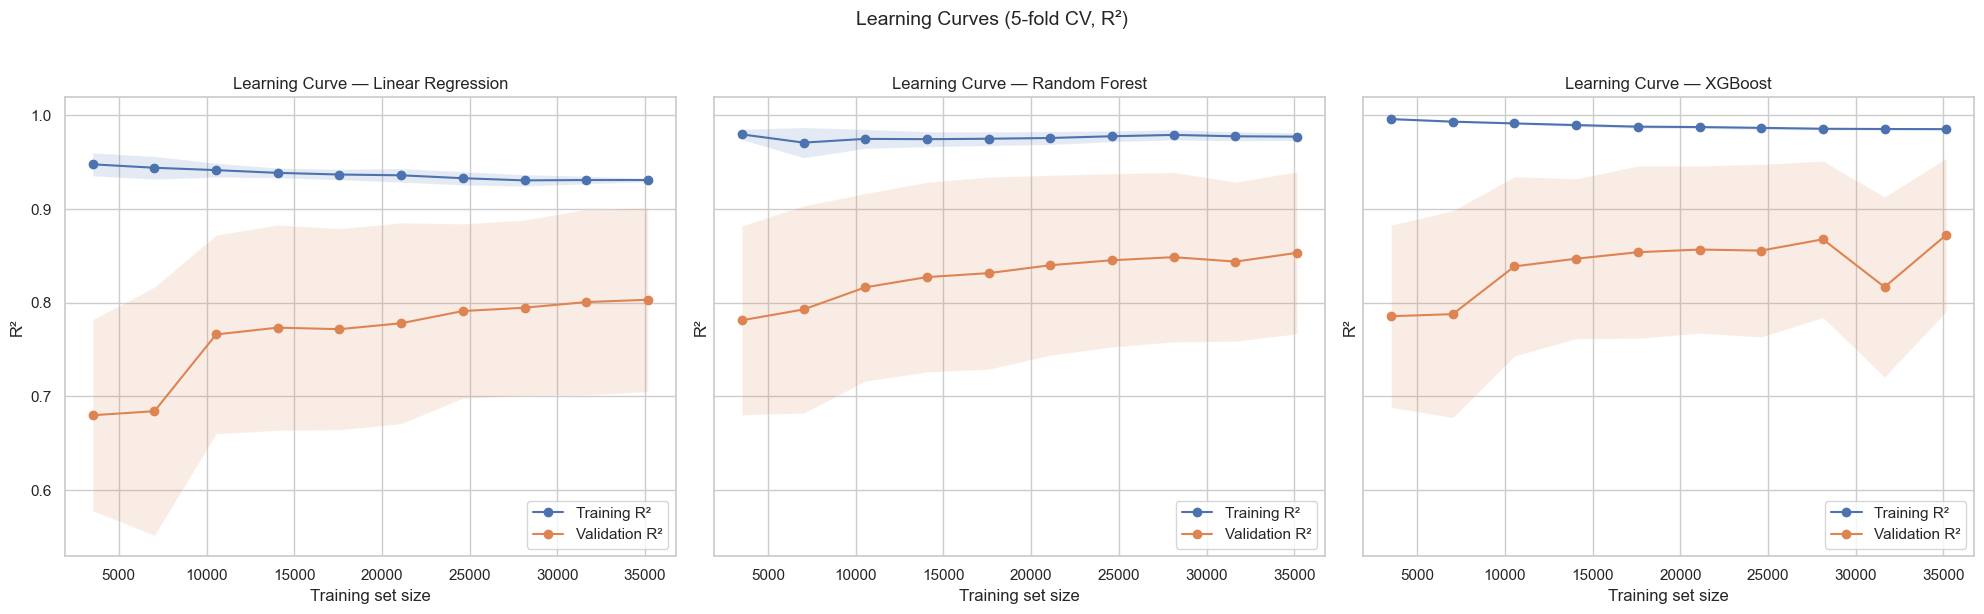

In [354]:
# --- 0) Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# --- 1) Features / target
target_col = "price_EUR"
X = df.drop(columns=[target_col])
y = df[target_col]

num_features = ["mileage_km", "hp", "car_age"]
cat_features = ["make", "model", "fuel_type", "Transmission", "new_or_used"]

# --- 2) OneHotEncoder that works across sklearn versions
# sklearn >=1.2 uses sparse_output, older uses sparse
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

# --- 3) Preprocessors
# Linear regression benefits from scaling numerics
pre_lr = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", ohe, cat_features),
    ],
    remainder="drop"
)

# Tree models: no scaling on numerics (keeps units meaningful)
pre_tree = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", ohe, cat_features),
    ],
    remainder="drop"
)

# --- 4) Model pipelines
pipe_lr = Pipeline([
    ("prep", pre_lr),
    ("model", LinearRegression())
])

pipe_rf = Pipeline([
    ("prep", pre_tree),
    ("model", RandomForestRegressor(
        n_estimators=300,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    ))
])

pipe_xgb = Pipeline([
    ("prep", pre_tree),
    ("model", XGBRegressor(
        n_estimators=600,
        max_depth=8,
        learning_rate=0.06,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="reg:squarederror",
        n_jobs=-1,
        random_state=42
    ))
])

models = {
    "Linear Regression": pipe_lr,
    "Random Forest":     pipe_rf,
    "XGBoost":           pipe_xgb
}

# --- 5) Learning curves for all three (R²)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
train_sizes_grid = np.linspace(0.1, 1.0, 10)

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

for ax, (name, est) in zip(axes, models.items()):
    ts, tr_scores, va_scores = learning_curve(
        est, X, y,
        train_sizes=train_sizes_grid,
        cv=cv,
        scoring="r2",
        n_jobs=-1,
        shuffle=True,
        random_state=42
    )
    ax.plot(ts, tr_scores.mean(axis=1), "o-", label="Training R²")
    ax.plot(ts, va_scores.mean(axis=1), "o-", label="Validation R²")
    ax.fill_between(ts,
                    tr_scores.mean(axis=1) - tr_scores.std(axis=1),
                    tr_scores.mean(axis=1) + tr_scores.std(axis=1),
                    alpha=0.15)
    ax.fill_between(ts,
                    va_scores.mean(axis=1) - va_scores.std(axis=1),
                    va_scores.mean(axis=1) + va_scores.std(axis=1),
                    alpha=0.15)
    ax.set_title(f"Learning Curve — {name}")
    ax.set_xlabel("Training set size")
    ax.set_ylabel("R²")
    ax.legend(loc="lower right")

fig.suptitle("Learning Curves (5-fold CV, R²)", y=1.02, fontsize=14)
fig.tight_layout()
plt.show()

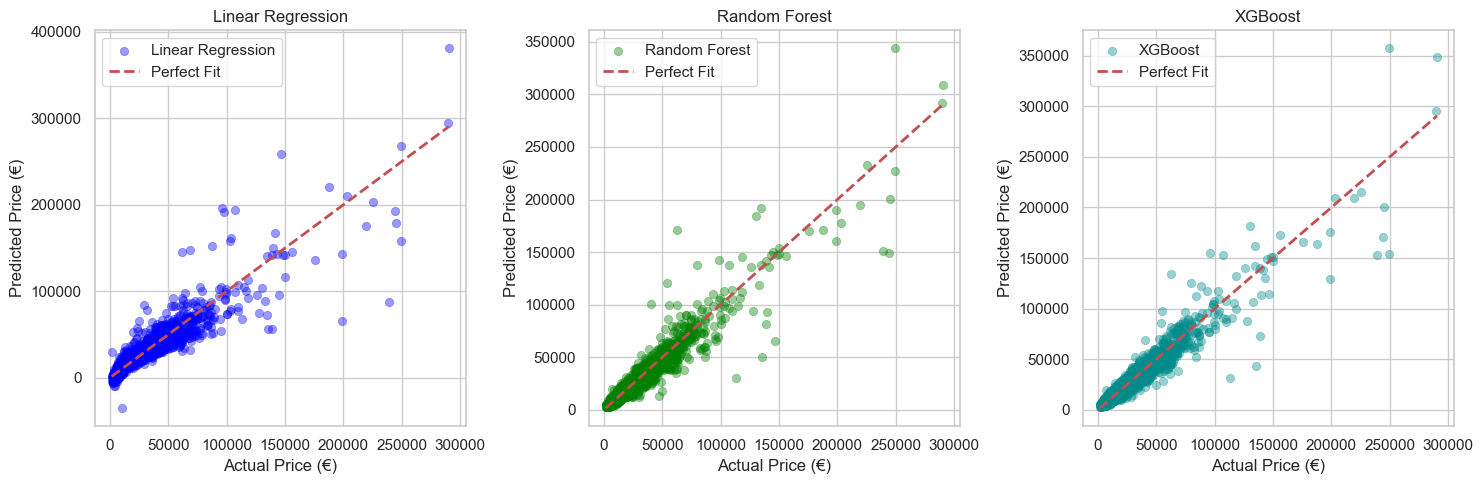

In [165]:
# Make predictions for residual analysis
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Residuals
residuals_lr = y_test - y_pred_lr
residuals_rf = y_test - y_pred_rf
residuals_xgb = y_test - y_pred_xgb

# Plot: Predicted vs Actual
plt.figure(figsize=(15, 5))

# Linear Regression
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_lr, color="blue", alpha=0.4, edgecolor=None, label="Linear Regression")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Linear Regression")
plt.legend()

# Random Forest
plt.subplot(1, 3, 2)
sns.scatterplot(x=y_test, y=y_pred_rf, color="green", alpha=0.4, edgecolor=None, label="Random Forest")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Random Forest")
plt.legend()

# XGBoost
plt.subplot(1, 3, 3)
sns.scatterplot(x=y_test, y=y_pred_xgb, color="darkcyan", alpha=0.4, edgecolor=None, label="XGBoost")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Perfect Fit")
plt.xlabel("Actual Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("XGBoost")
plt.legend()

plt.tight_layout()
plt.show()

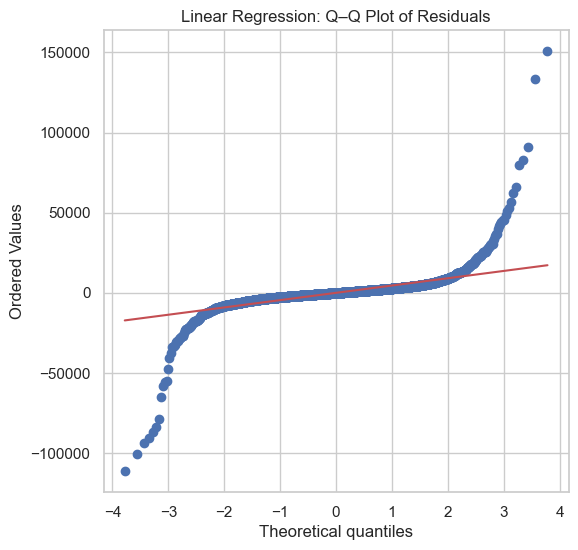

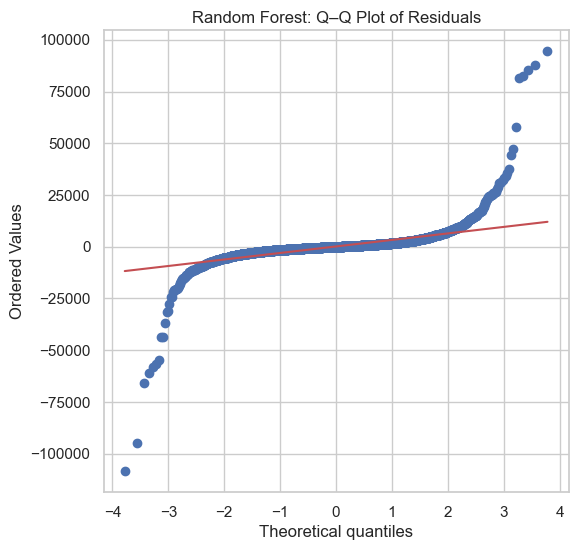

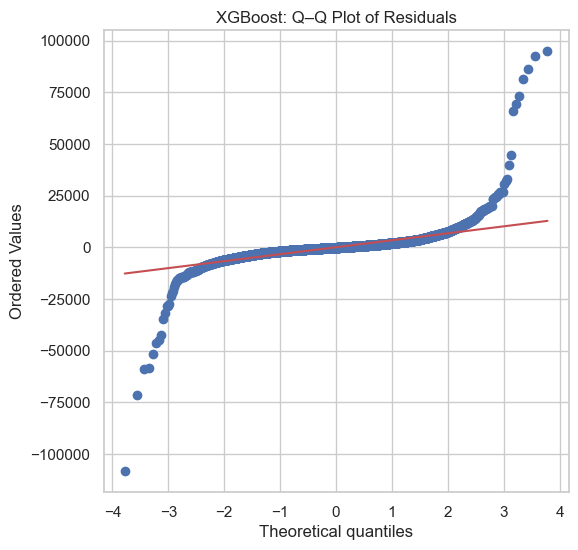

In [260]:
from scipy import stats

# Function: Generate Q–Q plots for residuals
# Purpose:
# - Checks if residuals follow a normal distribution (assumption in regression diagnostics)
# - Deviations in tails indicate skewness, kurtosis, or fat-tailed errors
# Parameters:
# - residuals: array of model residuals (y_true - y_pred)
# - model_name: string label for plot title
def qq_plot(residuals, model_name="Model"):
    plt.figure(figsize=(6, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"{model_name}: Q–Q Plot of Residuals")
    plt.show()

# --- Example usage for each model ---

# Linear Regression residuals
y_pred_lr = lr_model.predict(X_test)
resid_lr = y_test.values.ravel() - y_pred_lr.ravel()
qq_plot(resid_lr, model_name="Linear Regression")

# Random Forest residuals
y_pred_rf = rf_model.predict(X_test)
resid_rf = y_test.values.ravel() - y_pred_rf.ravel()
qq_plot(resid_rf, model_name="Random Forest")

# XGBoost residuals
y_pred_xgb = xgb_model.predict(X_test)
resid_xgb = y_test.values.ravel() - y_pred_xgb.ravel()
qq_plot(resid_xgb, model_name="XGBoost")



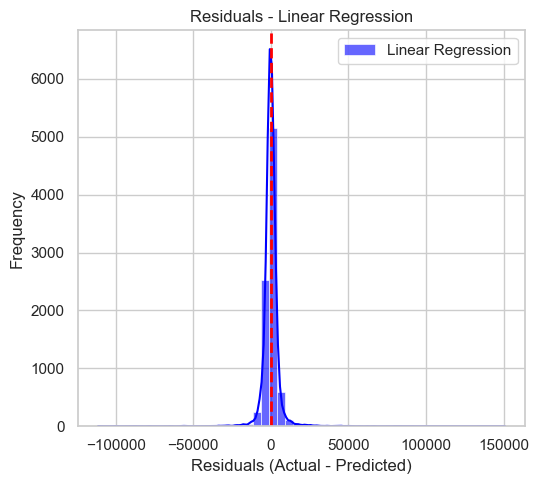

In [179]:
# Residual Distribution Plots
plt.figure(figsize=(15, 5))

# Linear Regression
plt.subplot(1, 3, 1)
sns.histplot(residuals_lr, bins=50, kde=True, color="blue", alpha=0.6, label="Linear Regression")
plt.axvline(0, color="red", linestyle="--", lw=2)
plt.title("Residuals - Linear Regression")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()


plt.tight_layout()
plt.show()

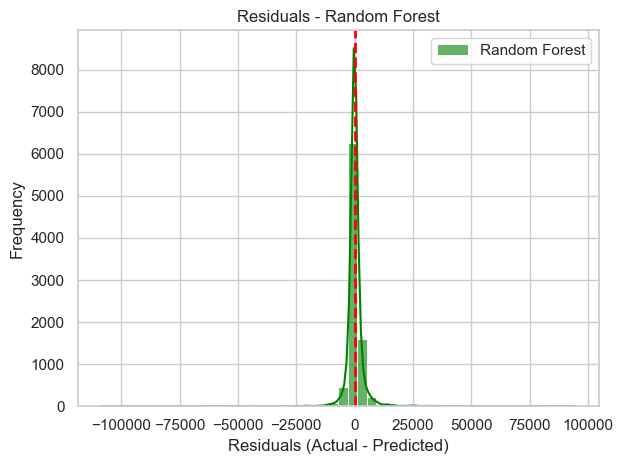

In [181]:
# Random Forest
plt.plot(1, 3, 3)
sns.histplot(residuals_rf, bins=50, kde=True, color="green", alpha=0.6, label="Random Forest")
plt.axvline(0, color="red", linestyle="--", lw=2)
plt.title("Residuals - Random Forest")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

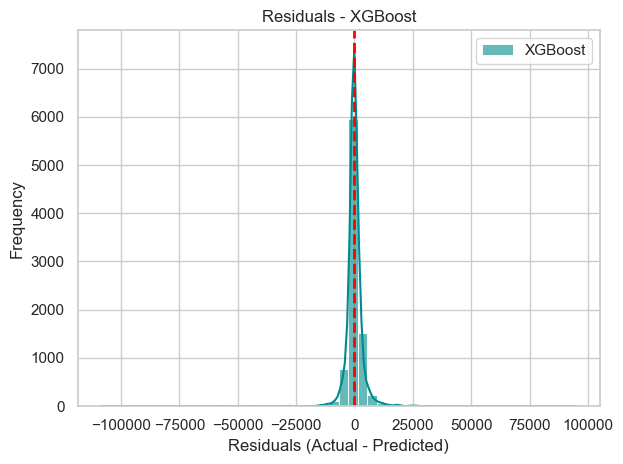

In [171]:
# XGBoost
plt.plot(1, 3, 3)
sns.histplot(residuals_xgb, bins=50, kde=True, color="darkcyan", alpha=0.6, label="XGBoost")
plt.axvline(0, color="red", linestyle="--", lw=2)
plt.title("Residuals - XGBoost")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

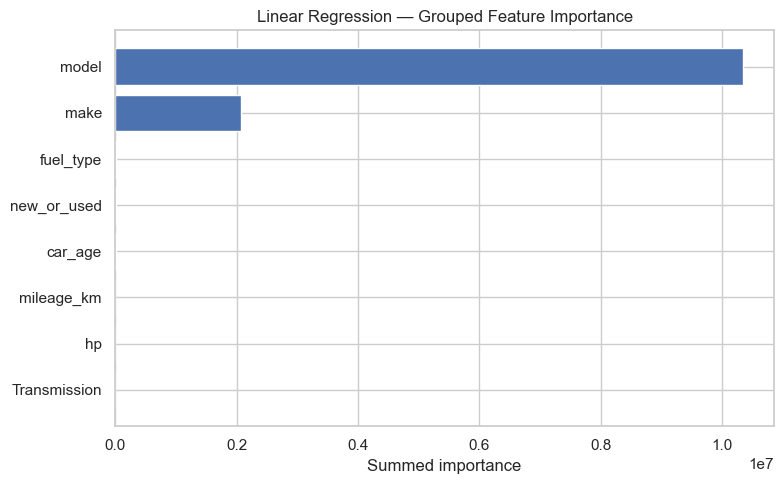

In [206]:
# --- Linear Regression: Feature Importance (via coefficients) ---

# Get feature names from the preprocessing pipeline
# - numeric_features: list of continuous variables
# - categorical_features: list of categorical variables (expanded by one-hot encoding)
lin_names = get_feature_names_from_preprocessor(
    lr_model, numeric_features, categorical_features
)

# Extract absolute coefficient values from the trained regression model
# - Coefficients indicate direction & magnitude of effect
# - Taking absolute values highlights overall strength of contribution
lin_coefs = np.abs(lr_model.named_steps["regressor"].coef_.ravel())

# Plot grouped feature importance (numeric features kept as-is, categorical grouped by prefix)
# - Helps interpret whether depreciation (age, mileage) or categorical factors (brand, model) dominate
# - top_n=10 restricts to the ten strongest predictors
lin_grouped = plot_grouped_importance(
    lin_names,
    lin_coefs,
    title="Linear Regression — Grouped Feature Importance",
    top_n=10)


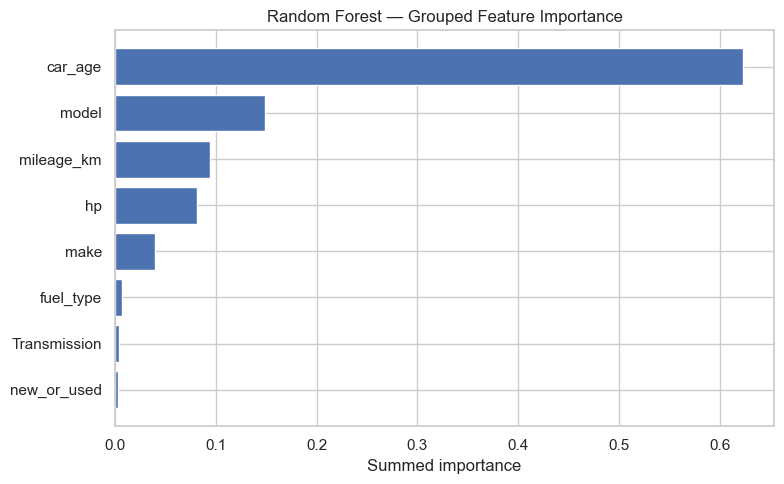

In [208]:
# Random Forest Feature Importance

rf_names = get_feature_names_from_preprocessor(rf_model, numeric_features, categorical_features)
rf_imp   = rf_model.named_steps["regressor"].feature_importances_

rf_grouped = plot_grouped_importance(rf_names, rf_imp,
    title="Random Forest — Grouped Feature Importance", top_n=10)

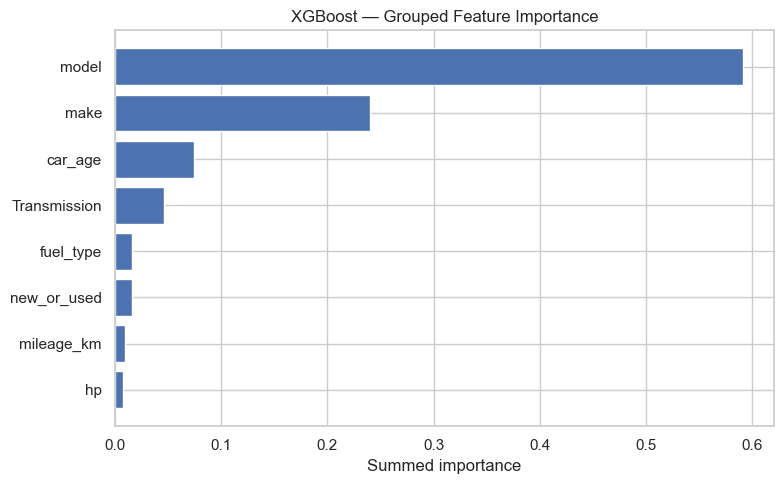

In [210]:
# XGBoost Feature Importance
xgb_names = get_feature_names_from_preprocessor(xgb_model, numeric_features, categorical_features)
xgb_imp   = xgb_model.named_steps["regressor"].feature_importances_

xgb_grouped = plot_grouped_importance(xgb_names, xgb_imp,
    title="XGBoost — Grouped Feature Importance", top_n=10)

/var/folders/wk/g1wcsyhj1yqccbrjstc2snh40000gn/T/ipykernel_27170/1934429706.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_used, x="era", y="price_EUR", palette="Set2", showfliers=False)


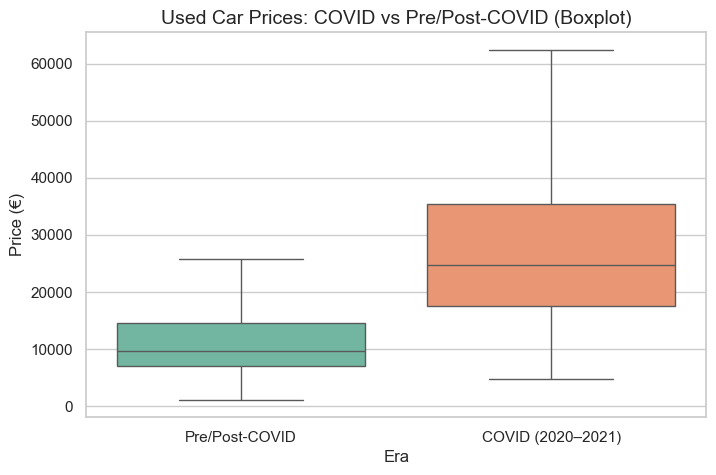

/var/folders/wk/g1wcsyhj1yqccbrjstc2snh40000gn/T/ipykernel_27170/1934429706.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_prices, x="era", y="price_EUR", palette="Set2")


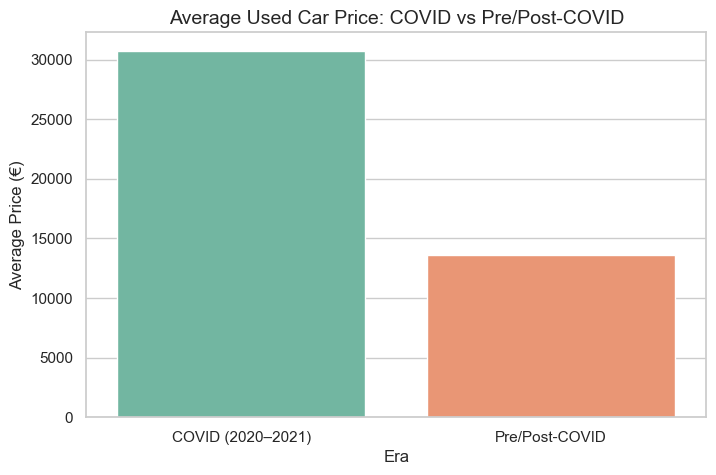

In [277]:
# Recreate the 'year' column from car_age (if missing)
if "year" not in df.columns:
    df["year"] = 2025 - df["car_age"]

# Keep only used cars
df_used = df[df["new_or_used"] == "Used"].copy()

# Create COVID vs non-COVID grouping
df_used["era"] = df_used["year"].apply(
    lambda x: "COVID (2020–2021)" if x in [2020, 2021] else "Pre/Post-COVID"
)

# --- Boxplot (distribution of prices) ---
plt.figure(figsize=(8,5))
sns.boxplot(data=df_used, x="era", y="price_EUR", palette="Set2", showfliers=False)
plt.title("Used Car Prices: COVID vs Pre/Post-COVID (Boxplot)", fontsize=14)
plt.xlabel("Era")
plt.ylabel("Price (€)")
plt.show()

# --- Bar Chart (average price) ---
avg_prices = df_used.groupby("era")["price_EUR"].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=avg_prices, x="era", y="price_EUR", palette="Set2")
plt.title("Average Used Car Price: COVID vs Pre/Post-COVID", fontsize=14)
plt.xlabel("Era")
plt.ylabel("Average Price (€)")
plt.show()

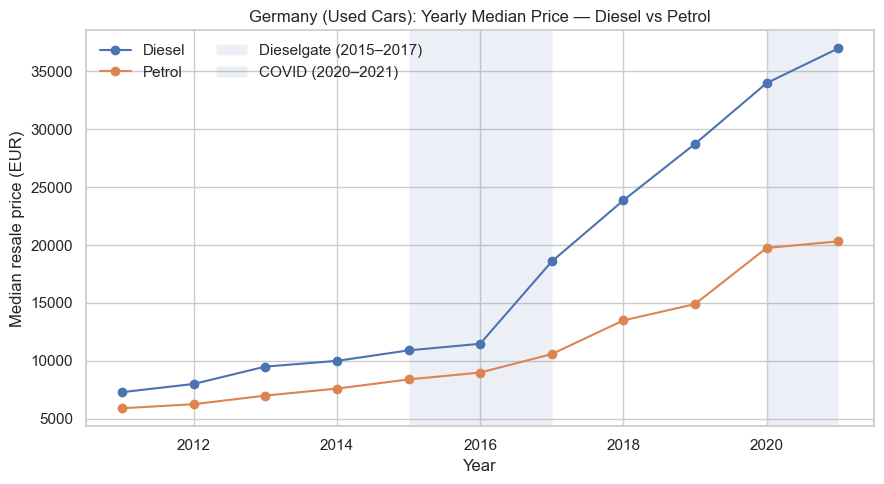

In [279]:
# --- Diesel vs Petrol price trends  ---


# 1) --- CONFIG: tell the code what column names are ---
PRICE_COL = next(c for c in ["price_EUR","price","Price_EUR","Price"] if c in df.columns)
FUEL_COL  = next(c for c in ["fuel_type","fuel","Fuel","Fuel_type"] if c in df.columns)
YEAR_COL  = next(c for c in ["year","Year","registration_year","first_reg_year"] if c in df.columns)
STATUS_COL= next((c for c in ["new_or_used","offer_type","offertype","status"] if c in df.columns), None)

# 2) --- Keep used cars only (if you have that column) ---
work = df.copy()
if STATUS_COL is not None:
    # normalise to {"Used","New"}; 
    valmap = {
        "used":"Used","Used":"Used","USED":"Used",
        "u":"Used","U":"Used","Gebraucht":"Used",
        "new":"New","New":"New","NEW":"New",
        "n":"New","N":"New","Neu":"New"
    }
    work["__status__"] = work[STATUS_COL].map(valmap).fillna(work[STATUS_COL])
    work = work[work["__status__"]=="Used"].copy()

# 3) --- Clean/standardise fuel labels a bit ---
fuel_map = {
    "diesel":"Diesel","Diesel":"Diesel",
    "petrol":"Petrol","gasoline":"Petrol","benzin":"Petrol","Gasoline":"Petrol","Benzin":"Petrol"
}
work["__fuel__"] = work[FUEL_COL].astype(str).str.strip()
work["__fuel__"] = work["__fuel__"].str.lower().map(fuel_map).fillna(work["__fuel__"])

# 4) --- Basic sanity filters ---
work = work[[YEAR_COL, PRICE_COL, "__fuel__"]].copy()
work[PRICE_COL] = pd.to_numeric(work[PRICE_COL], errors="coerce")
work[YEAR_COL]  = pd.to_numeric(work[YEAR_COL], errors="coerce")
work = work.dropna(subset=[PRICE_COL, YEAR_COL])
work = work[(work[PRICE_COL] > 0) & (work[YEAR_COL] >= 2008) & (work[YEAR_COL] <= 2025)]

# 5) --- Focus on Diesel vs Petrol only ---
mask = work["__fuel__"].isin(["Diesel","Petrol"])
fuel_df = work.loc[mask].copy()

# 6) --- Yearly median price (robust to outliers); also add a light smoothing
yearly = (fuel_df
          .groupby([YEAR_COL, "__fuel__"])[PRICE_COL]
          .median()
          .rename("median_price")
          .reset_index())

# Optional: 3-year rolling median by fuel for a smoother line
yearly = (yearly
          .sort_values([ "__fuel__", YEAR_COL])
          .assign(roll_med=lambda d: d.groupby("__fuel__")["median_price"].transform(
              lambda s: s.rolling(3, min_periods=1, center=True).median()
          )))

# 7) --- Plot ---
plt.figure(figsize=(9,5))
for fuel in ["Diesel","Petrol"]:
    ysub = yearly[yearly["__fuel__"]==fuel]
    plt.plot(ysub[YEAR_COL], ysub["roll_med"], marker="o", label=fuel)  # uses default colors

# Mark Dieselgate (2015–2017) and COVID (2020–2021)
plt.axvspan(2015, 2017, alpha=0.1, label="Dieselgate (2015–2017)")
plt.axvspan(2020, 2021, alpha=0.1, label="COVID (2020–2021)")

plt.title("Germany (Used Cars): Yearly Median Price — Diesel vs Petrol")
plt.xlabel("Year")
plt.ylabel("Median resale price (EUR)")
plt.legend(loc="upper left", ncol=2, frameon=False)
plt.tight_layout()
plt.show()


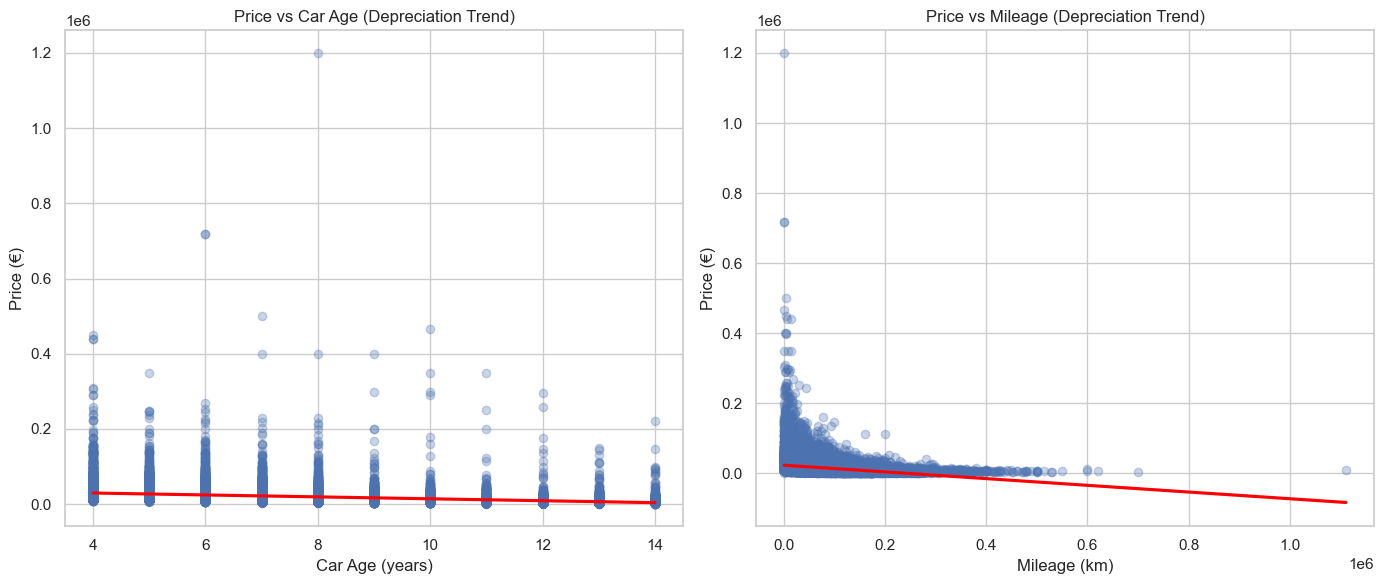

In [283]:
plt.figure(figsize=(14, 6))

# --- Price vs Car Age ---
# Scatterplot with regression line to visualise depreciation over time.
# Expectation: negative relationship (older cars → lower prices).
plt.subplot(1, 2, 1)
sns.regplot(
    data=df,
    x="car_age",
    y="price_EUR",
    scatter_kws={'alpha': 0.3},   # lower opacity for readability
    line_kws={'color': 'red'}     # regression trend line
)
plt.title("Price vs Car Age (Depreciation Trend)")
plt.xlabel("Car Age (years)")
plt.ylabel("Price (€)")

# --- Price vs Mileage ---
# Scatterplot with regression line to visualise wear-and-tear effect.
# Expectation: higher mileage → lower prices, though with greater variance than age.
plt.subplot(1, 2, 2)
sns.regplot(
    data=df,
    x="mileage_km",
    y="price_EUR",
    scatter_kws={'alpha': 0.3},
    line_kws={'color': 'red'}
)
plt.title("Price vs Mileage (Depreciation Trend)")
plt.xlabel("Mileage (km)")
plt.ylabel("Price (€)")

# Adjust layout for cleaner presentation
plt.tight_layout()
plt.show()